
> **ISO2024 INTRODUCTORY SPATIAL 'OMICS ANALYSIS**
>
>
>- HYBRID : TORONTO & ZOOM
>- 9TH JULY 2024 <br>


>**Module 4 PRE-WORK - Supplementary file 1 <br>
>**Instructor : Shamini Ayyadhury**

---

```
Supplementary script 02 : PREPARING THE FOLLOWING FILES FOR SEGMENTATION AND SEG-FREE ANALYSIS

    1. CROPPED IMAGE OF ALL 4 CHANNELS 
    2. COMPOSITE IMAGE OF ALL 4 CHANNELS COMBINED
    3. SUBSETTED TRANSCRIPTS FILE MATCHING THE CROPPED IMAGE DIMENSIONS
    4. SUBSETTED CELL AND NUCLEAR BOUNDARIES FILES MATCHING THE CROPPED IMAGE DIMENSIONS
    

In [1]:
### import the following libraries
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
#from PIL import Image
import os
import warnings
import tifffile as tiff

warnings.filterwarnings('ignore')


sys.path.append('/home/shamini/data/projects/spatial_workshop/')
import pre_processing_fnc as ppf # import memory usage function only


In [2]:
### directory & filepaths
data_dir = '/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/cell_seg_brain_cancer/'
out = '/home/shamini/data/projects/spatial_workshop/out/module4/'
os.makedirs(out, exist_ok=True) # create a new directory to store the output files


In [3]:
transcripts = 'transcripts.parquet'
image = 'morphology_focus_0000.ome.tif'

In [4]:
df_transcript = pd.read_parquet(data_dir+'out/'+transcripts)
iF = tiff.imread(data_dir+'out/morphology_focus/'+image)

#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


'Memory usage: 32476.46 MB'

The scale factor is required to convert the metric units of the transcript coordinates into pixel units to ensure that we ca superimpose the image, transcripts and polygon information precisely.

In [5]:
scale = 0.2125 ### size of each pixel in microns

In order to convert the um scale to a pixel scale, we need to divide each transcript coordinate unit (um) by the pixel size (um/pixel)

In [7]:
df_transcript[['x_location']] = df_transcript[['x_location']]/scale
df_transcript[['y_location']] = df_transcript[['y_location']]/scale

Crop and subset

In [8]:
'''
I have arbitrarily chosen the following coordinates to crop the image. The reason for this choice was 
1. To have a smaller image to work with during the tutorials
2. To select regions that had different cell-types including blood vessels.
'''

xmin_cut = int(10000/scale)
xmax_cut = int(11000/scale)

ymin_cut = int(6000/scale)
ymax_cut = int(7000/scale)

print(xmin_cut, xmax_cut, ymin_cut, ymax_cut)

47058 51764 28235 32941


Subset the transcripts file

'Memory usage: 34394.51 MB'

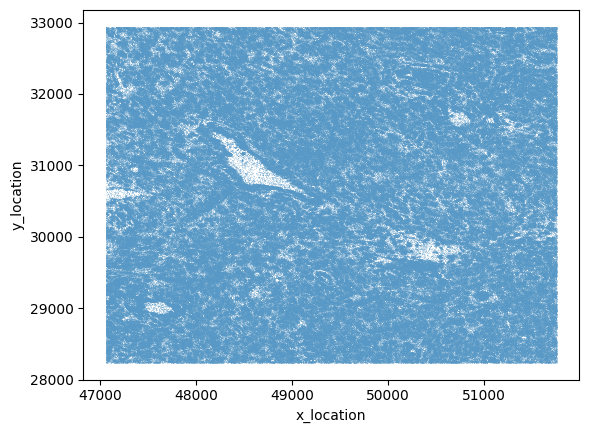

In [9]:
transcripts_subset = df_transcript[((df_transcript['x_location'] > xmin_cut) & (df_transcript['x_location'] < xmax_cut)) & ((df_transcript['y_location'] > ymin_cut) & (df_transcript['y_location'] < ymax_cut))]
sns.scatterplot(data=transcripts_subset, x='x_location', y='y_location', s=.1)

#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

In [10]:

processed_tf = ppf.process_data(transcripts_subset)
processed_tf = processed_tf[processed_tf['group']=='gene_probes']

#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage


'Memory usage: 34504.49 MB'

Once we subset the transcript file, we will find the minimum and maximum y and x pixel coordinates, convert them to intergers, before using these to offset the coordinates to fit the cropped image coordinates.

Note : why is this step important? 
1. Because the cropped image will automatically revert to a (0,0) origin and to ensure effective image to transcript registration, the coordinate system has to be reset. 
2. It is important to use an integer value as while the transcript spatial coordinate framework is on a continous scale, the image scale is discrete. (the image will read an error when you try to offset it by a float)

In [11]:
### has ot be an integer as images are not on a continous scale transcript coordinates are

min_x = int(processed_tf['x_location'].min())
max_x = int(processed_tf['x_location'].max())

min_y = int(processed_tf['y_location'].min())
max_y = int(processed_tf['y_location'].max())


In [13]:

transcripts_subset = processed_tf

In [14]:
print(min_x, max_x, min_y, max_y)

47058 51763 28235 32940


reset the coordinates to ensure it matches with the cropped image

In [22]:
transcripts_subset = transcripts_subset[transcripts_subset['qv']>20]
transcripts_subset

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,group,binary
161287021,282462819196899,jghlagom-1,0,CTNNB1,0.515625,803.724609,21.914780,40.000000,Z17,0.415854,171,gene_probes,assigned
161287022,282462819196900,jpcfbjbg-1,0,CTNNB1,0.097656,152.208984,23.486221,40.000000,Z17,0.828315,171,gene_probes,assigned
161287023,282462819196903,jghbfook-1,0,CTNNB1,0.445312,58.417969,20.532825,40.000000,Z17,0.276219,171,gene_probes,assigned
161287024,282462819211341,jpcfbjbg-1,0,CD83,0.292969,185.755859,21.277554,40.000000,Z17,0.324890,144,gene_probes,assigned
161287025,282462819211343,jghcidji-1,1,NOTCH2,0.410156,219.052734,19.567415,40.000000,Z17,0.000000,290,gene_probes,assigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170296967,281513632352447,jlkdapch-1,0,PDGFRA,4704.609375,3799.017578,23.134159,40.000000,AA19,0.641113,173,gene_probes,assigned
170296968,281513632352448,jlkfdjad-1,0,EDNRB,4704.542969,4312.632812,21.262211,31.155910,AA19,0.309570,427,gene_probes,assigned
170296969,281513632352449,jlgeaoha-1,0,CDK4,4704.789062,4625.781250,22.501923,40.000000,AA19,0.413626,146,gene_probes,assigned
170296971,281513632352452,jlkgiamb-1,0,CAV1,4704.578125,4076.347656,22.465912,28.720749,AA19,2.884766,478,gene_probes,assigned


In [15]:
### reset the coordinates to 0
transcripts_subset['x_location'] = transcripts_subset['x_location'] - min_x
transcripts_subset['y_location'] = transcripts_subset['y_location'] - min_y


In [23]:

### this file will be used subsquently for baysor segmentationa and seg free analysis
transcripts_subset.to_csv(out+'/transcripts_subset_all_genes.csv')

'Memory usage: 34462.24 MB'

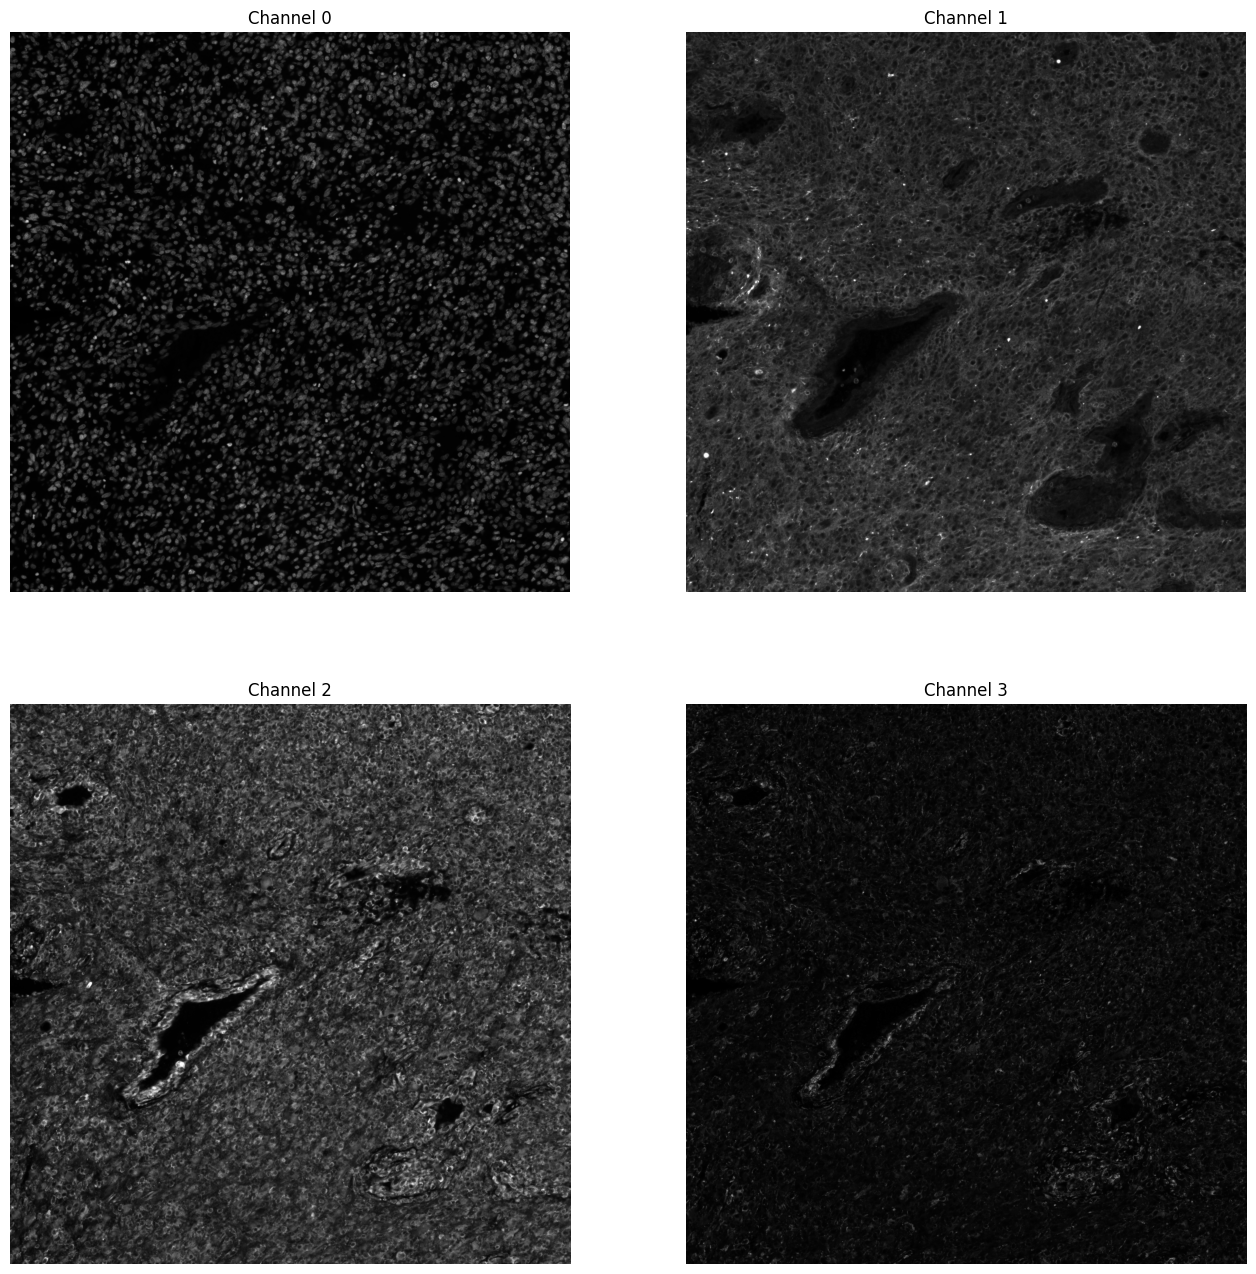

In [16]:
### crop the image
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
iF_crop = iF[:, min_y:max_y, min_x:max_x]
ax = ax.flatten()

for channel in range(4):
    ax[channel].imshow(iF_crop[channel], cmap='gray')
    ax[channel].axis('off')
    ax[channel].set_title(f'Channel {channel}') 
    
#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

In [17]:
### save the cropped image
tiff.imsave(out+'/cropped_image_fluo.tif', iF_crop)

Test if a common coordinate framework is maintained by plotting the transcripts over the image

'Memory usage: 36375.26 MB'

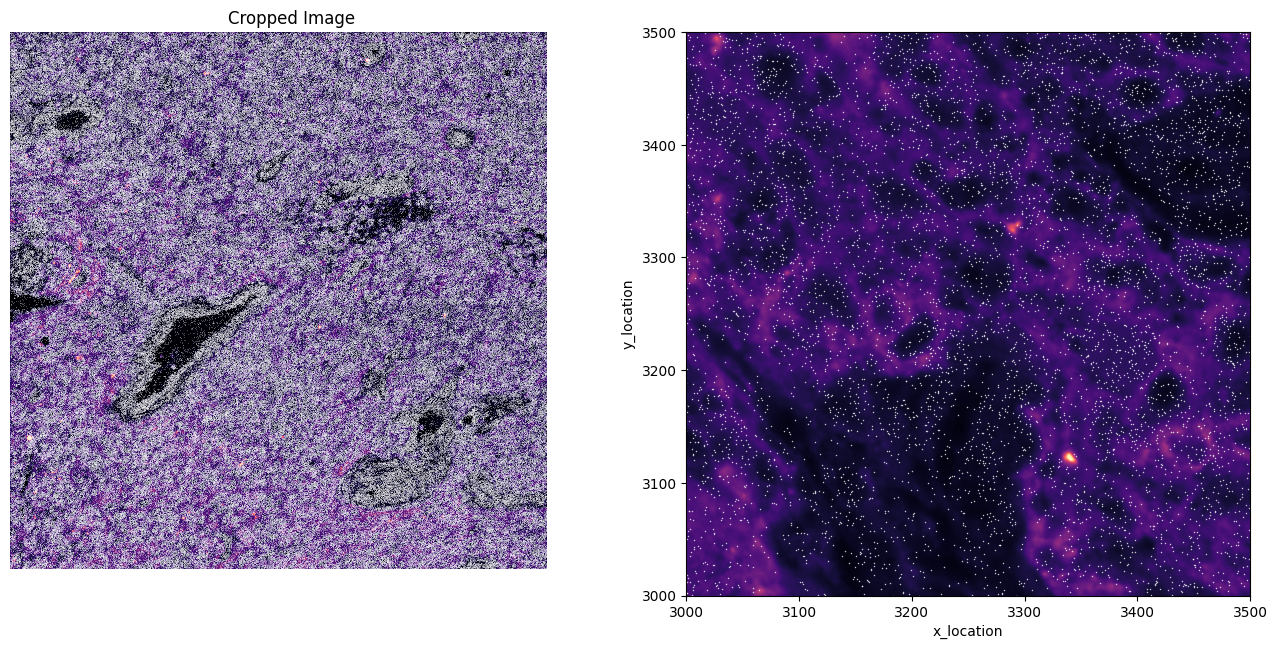

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
transcripts_subset_sample = transcripts_subset.sample(frac=0.3, random_state=1)

axes[0].imshow(iF_crop[1,:,:], cmap='magma')
ax = sns.scatterplot(data=transcripts_subset_sample, x='x_location', y='y_location', s=0.3, ax=axes[0], alpha=0.5, color='white')
axes[0].set_title('Cropped Image')
axes[0].axis('off')

axes[1].imshow(iF_crop[1,:,:], cmap='magma')
ax = sns.scatterplot(data=transcripts_subset_sample, x='x_location', y='y_location', s=0.9, ax=axes[1], alpha=0.75, color='white')
ax.set_xlim(3000, 3500)
ax.set_ylim(3000, 3500)


#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

Next, repeat the same for the polygons for cell and nuclear boundaries

In [25]:
### import cell boundaries and nuclear boundaries files
cell_boundaries = pd.read_parquet(data_dir+'out/cell_boundaries.parquet')
nuclear_boundaries = pd.read_parquet(data_dir+'out/nucleus_boundaries.parquet')


#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 36899.14 MB'

In [26]:
cell_boundaries = cell_boundaries[cell_boundaries['cell_id'].isin(df_transcript['cell_id'])]
cell_boundaries['vertex_x'] = (cell_boundaries['vertex_x']/0.2125)
cell_boundaries['vertex_y'] = (cell_boundaries['vertex_y']/0.2125)

nuclear_boundaries = nuclear_boundaries[nuclear_boundaries['cell_id'].isin(df_transcript['cell_id'])]
nuclear_boundaries['vertex_x'] = (nuclear_boundaries['vertex_x']/0.2125)
nuclear_boundaries['vertex_y'] = (nuclear_boundaries['vertex_y']/0.2125)


#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 36691.82 MB'

In [27]:
### shift the coordinates to match the cropped image
cell_boundaries['vertex_x'] = cell_boundaries['vertex_x'] - min_x
cell_boundaries['vertex_y'] = cell_boundaries['vertex_y'] - min_y

nuclear_boundaries['vertex_x'] = nuclear_boundaries['vertex_x'] - min_x
nuclear_boundaries['vertex_y'] = nuclear_boundaries['vertex_y'] - min_y

#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 36691.82 MB'

In [28]:
cell_boundaries.to_parquet(out+'cell_boundaries_subset.parquet')
nuclear_boundaries.to_parquet(out+'nuclear_boundaries_subset.parquet')

#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 36656.59 MB'

In addition, we provide with a matched cropped anndata object of the adata file transformed in script 1

In [29]:
#### subset adata to the cropped image

adata = sc.read_h5ad(out+'adata.h5ad')
print(f'Adata before cropping:\n {adata}\n')
adata_crop = adata[adata.obs.index.isin(transcripts_subset['cell_id']),:]
print(f'Adata after cropping:\n {adata_crop}')


#----------------------------------------------
ppf.get_memory_usage() ### monitor memory usage

Adata before cropping:
 AnnData object with n_obs × n_vars = 815294 × 480
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Adata after cropping:
 View of AnnData object with n_obs × n_vars = 8156 × 480
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    

'Memory usage: 38727.26 MB'

For the segmentation module, we will be evaluating 3 genes to better understand how the different segmetnation parameters affect transcript assignment and cell-type interpretation

In [30]:
genes = ['PTPRC', 'ANXA1', 'STMN1']

adata_3g = adata_crop[:,genes]
adata_3g.write_h5ad(out+'adata_3g.h5ad')   
adata_crop.write_h5ad(out+'adata_subset.h5ad') 

In [31]:
transcripts_subset_3g = transcripts_subset[transcripts_subset['feature_name'].isin(genes)]
transcripts_subset_3g.to_csv(out+'transcripts_subset_3g.csv', index=False)

In [32]:
cell_boundaries = cell_boundaries[cell_boundaries['cell_id'].isin(transcripts_subset['cell_id'])]
nuclear_boundaries = nuclear_boundaries[nuclear_boundaries['cell_id'].isin(transcripts_subset['cell_id'])]

cell_boundaries.to_csv(out+'cell_boundaries_subset.csv', index=False)
nuclear_boundaries.to_csv(out+'nuclear_boundaries_subset.csv', index=False) 